In [49]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)

In [50]:
# read in data

dataframe = pd.read_csv('https://raw.githubusercontent.com/yuezheli/COVIDpred/main/CleanedData.csv', header = 0)

dataframe['Date'] = pd.to_datetime(dataframe['Date'])


# use Connecticut data 
ct = dataframe[dataframe['state'] == 'Connecticut']

newconfirmed= np.zeros([len(ct)])
newdeath = np.zeros([len(ct)])

for i in range(len(ct)-1):
    newconfirmed[i+1] = ct['confirmed'].iloc[i+1] - ct['confirmed'].iloc[i] 
    newdeath[i+1] = ct['death'].iloc[i+1] - ct['death'].iloc[i] 

ct['added confirmed'] = newconfirmed
ct['added death'] = newdeath

ct.set_index('Date', drop = True, inplace = True)

ct.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,confirmed,death,state,added confirmed,added death
Date,,,,,
2020-01-22,0,0,Connecticut,0.0,0.0
2020-01-23,0,0,Connecticut,0.0,0.0
2020-01-24,0,0,Connecticut,0.0,0.0
2020-01-25,0,0,Connecticut,0.0,0.0
2020-01-26,0,0,Connecticut,0.0,0.0


In [84]:
dataset = pd.DataFrame(ct['added confirmed'], columns = ['added confirmed'])

#dataset['days'] = range(len(ct))

#dataset.reset_index(drop=True)

dataset

,added confirmed
Date,
2020-01-22,0.0
2020-01-23,0.0
2020-01-24,0.0
2020-01-25,0.0
2020-01-26,0.0
...,...
2020-12-02,2672.0
2020-12-03,4751.0
2020-12-04,1538.0


In [97]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)


In [98]:
# split into train and test sets
train_size = int(len(dataset) * 280/320)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [119]:
def LookBackSize(look_back = 4, train = train, test = test):
  # reshape into X=t and Y=t+1
  look_back = 4
  trainX, trainY = create_dataset(train, look_back)
  testX, testY = create_dataset(test, look_back)
  # reshape input to be [samples, time steps, features]
  trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
  testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
  
  # create and fit the LSTM network
  batch_size = 1
  model = Sequential()
  model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
  model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  
  i = 0
  while i < 150:
    history = model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()
    i = i + 1 
    if history.history['loss'][0] < 0.001:
      break
      
  # see final loss
  print(history.history['loss'])

  # make predictions
  trainPredict = model.predict(trainX, batch_size=batch_size)
  model.reset_states()
  testPredict = model.predict(testX, batch_size=batch_size)

  # invert predictions
  trainPredict = scaler.inverse_transform(trainPredict)
  trainY = scaler.inverse_transform([trainY])
  testPredict = scaler.inverse_transform(testPredict)
  testY = scaler.inverse_transform([testY])
  
  # print train score
  # calculate root mean squared error
  trainScore = mean_squared_error(trainY[0], trainPredict[:,0], squared=False)
  print('Train Score: %.2f RMSE' % (trainScore))
  return trainScore, model, history.history['loss']




In [114]:
# model selection

trainscores = []
error = []

for lookbacksize in range(7):
  tmpscore, _, tmperr = LookBackSize(look_back = lookbacksize + 1)
  trainscores.append(tmpscore)
  error.append(tmperr)
  del tmpscore, tmperr



275/275 - 3s - loss: 0.0030
275/275 - 1s - loss: 0.0041
275/275 - 1s - loss: 0.0041
275/275 - 1s - loss: 0.0040
275/275 - 1s - loss: 0.0039
275/275 - 1s - loss: 0.0038
275/275 - 1s - loss: 0.0037
275/275 - 1s - loss: 0.0035
275/275 - 1s - loss: 0.0033
275/275 - 1s - loss: 0.0032
275/275 - 1s - loss: 0.0031
275/275 - 1s - loss: 0.0030
275/275 - 1s - loss: 0.0029
275/275 - 1s - loss: 0.0029
275/275 - 1s - loss: 0.0028
275/275 - 1s - loss: 0.0028
275/275 - 1s - loss: 0.0028
275/275 - 1s - loss: 0.0027
275/275 - 1s - loss: 0.0027
275/275 - 1s - loss: 0.0027
275/275 - 1s - loss: 0.0027
275/275 - 1s - loss: 0.0027
275/275 - 1s - loss: 0.0027
275/275 - 1s - loss: 0.0027
275/275 - 1s - loss: 0.0026
275/275 - 1s - loss: 0.0026
275/275 - 1s - loss: 0.0026
275/275 - 1s - loss: 0.0026
275/275 - 1s - loss: 0.0026
275/275 - 1s - loss: 0.0026
275/275 - 1s - loss: 0.0026
275/275 - 1s - loss: 0.0026
275/275 - 1s - loss: 0.0026
275/275 - 1s - loss: 0.0026
275/275 - 1s - loss: 0.0026
275/275 - 1s - loss:

[0.04872109053861772,
 0.049096621521727425,
 0.05053709711356614,
 0.04528705213371255,
 0.04858659660050341,
 0.047025349073849025,
 0.04972420501870226]

In [115]:
trainscores

[0.04872109053861772,
 0.049096621521727425,
 0.05053709711356614,
 0.04528705213371255,
 0.04858659660050341,
 0.047025349073849025,
 0.04972420501870226]

In [ ]:
# model selected and prediction

_, model,_ = LookBackSize(look_back = 4)

trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)


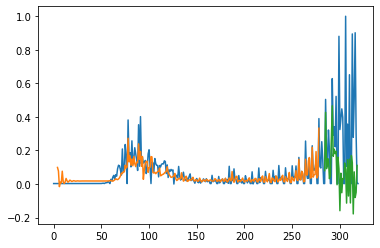

In [122]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [123]:
mean_squared_error(testY[0], testPredict[:,0], squared=False)/np.mean( testY[0] )

1.228876798850198